In [2]:
from upload_data import *
from utils import *
import pandas as pd
import time
import dask
%reload_ext autoreload
%autoreload 2

Parallelization when uploading the files.
We parallelize on load_all_dates which loads a single df for given dates. We parallelize for all the tickers (i.e we call in parallel load_all_dates #tickers times). 
Parallelization is not always optimal as we call 
`all_events = pd.concat(all_events, axis = 0)` with `all_events` being a list of dataframes stored in the memory of different cores or at least not in the memory of a single core. The advantage of parallelizing load_all_dates is removed by the increase in time taken by pd.concat from all dfs in the same core memory to dfs stored in the computer memory or the memory of different cores. 

To avoid this issue, we tried to transform them to vaex files and use the concat method of vaex but the transformation from pandas to vaex was to time-demanding.

We then tried to use dask data_frames in `load_all_dask` -> not more efficient...

In [145]:
%%time
#No parallelization
df = load_all_dates(ticker = 'AA.N', start_date = pd.to_datetime('2008-12-26'), end_date=pd.to_datetime('2008-12-31'))

CPU times: total: 391 ms
Wall time: 20.4 s


In [142]:
%%time
#Parallelization
df = load_all_dates(ticker = 'AA.N', start_date = pd.to_datetime('2008-12-26'), end_date=pd.to_datetime('2008-12-31'))

CPU times: total: 438 ms
Wall time: 5.37 s


In [23]:
%%time
df_ = load_all_dask(start_date = pd.to_datetime('2008-09-15'), end_date=pd.to_datetime('2008-12-31'))



Starting computations
Time to concat all data:  0.09976005554199219
Time to compute all data:  124.95039129257202
CPU times: total: 3min 24s
Wall time: 3min 2s


In [12]:
%%time
df_ = load_all(start_date = pd.to_datetime('2008-09-15'), end_date=pd.to_datetime('2008-12-31'))

Time to compute all data:  53.78907561302185
Time to concat all data:  3.750546455383301
CPU times: total: 1min 1s
Wall time: 58.7 s


In [10]:
%%time
#not in parallel
df_2 = load_all(start_date = pd.to_datetime('2008-09-15'), end_date=pd.to_datetime('2008-12-31'))

Time to compute all data:  67.98057556152344
Time to concat all data:  17.238533973693848
CPU times: total: 1min 12s
Wall time: 1min 26s


In [22]:
del df_

In [9]:
df_2.dropna(inplace=True)

In [12]:
import vaex
df_vaex = vaex.from_pandas(df_, copy_index=True)
df_vaex_2 = vaex.from_pandas(df_2, copy_index=True)

In [11]:
%%time
df_final_pandas = pd.concat([df_, df_2], axis=0)

CPU times: total: 13.1 s
Wall time: 38.1 s


In [14]:
%%time
df_final_vaex = vaex.concat([df_vaex, df_vaex_2])

CPU times: total: 0 ns
Wall time: 2.99 ms


In [15]:
%%time
df_final_pandas


CPU times: total: 0 ns
Wall time: 0 ns


,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,day,time,ticker
xltime,,,,,,,,,
2008-06-02 09:30:15.224000256-04:00,NaN,NaN,40.25,426.0,40.33,2.0,2008-06-02,09:30:15.224000,AA.N
2008-06-02 09:30:15.255000576-04:00,40.25,125100.0,NaN,NaN,NaN,NaN,2008-06-02,09:30:15.255000,AA.N
2008-06-02 09:30:15.404000256-04:00,40.25,1000.0,NaN,NaN,NaN,NaN,2008-06-02,09:30:15.404000,AA.N
2008-06-02 09:30:15.436000512-04:00,NaN,NaN,40.25,416.0,40.31,9.0,2008-06-02,09:30:15.436000,AA.N
2008-06-02 09:30:15.459000064-04:00,NaN,NaN,40.25,413.0,40.31,5.0,2008-06-02,09:30:15.459000,AA.N
...,...,...,...,...,...,...,...,...,...
2008-12-31 15:59:45.152999424-05:00,18.57,600.0,18.57,423.0,18.59,43.0,2008-12-31,15:59:45.152999,AXP.N
2008-12-31 15:59:46.168999680-05:00,18.57,400.0,18.57,386.0,18.58,16.0,2008-12-31,15:59:46.168999,AXP.N
2008-12-31 15:59:50.801000448-05:00,18.57,300.0,18.57,352.0,18.58,6.0,2008-12-31,15:59:50.801000,AXP.N


In [17]:
%%time
df_final_vaex_to_pandas = df_final_vaex.to_pandas_df()

CPU times: total: 40.5 s
Wall time: 2min 25s


In [98]:
%%time
all_data.compute()

TypeError: cannot concatenate object of type '<class 'dask.delayed.Delayed'>'; only Series and DataFrame objs are valid

In [160]:
import dask
import time

from joblib import delayed

def myadd(a,b):
    time.sleep(1)
    a = increment(a)
    b = increment(b)
    return a+b
@delayed
def increment(a):
    time.sleep(1)
    return a+1



In [161]:
%%time
@dask.delayed
def add(a,b):
    return a+b

a=1
b= np.arange(10)

c = [dask.delayed(add)(a,b_i) for b_i in b]

CPU times: total: 0 ns
Wall time: 5.99 ms


In [162]:
#compute all the promises
print(c)
c.visualize()
results = dask.compute(*c)

print(results)

[Delayed('add-276e2893-b43d-42f3-9fc2-8cfbc098e49c'), Delayed('add-12390ad5-9dc5-4350-82bf-7d99ae404011'), Delayed('add-10f2c0ef-a9fb-47cc-a965-66db37ea6d73'), Delayed('add-eb9ad766-8455-4865-8c7b-f11e44063645'), Delayed('add-bf37e8e6-ae5f-42b4-a012-3b8c2cad7b6a'), Delayed('add-fe857cff-648c-4afb-b19f-390818ad2869'), Delayed('add-c483485d-2c9a-44df-8405-534fd586b786'), Delayed('add-0f856443-6100-410e-b1aa-ea16ac4a65d5'), Delayed('add-cc12e62d-8cf7-4ac7-bf26-ba9dda41b75a'), Delayed('add-89f9deed-97c2-44d8-ad9d-ef55d9449f67')]


AttributeError: 'list' object has no attribute 'visualize'

In [114]:
%%time
c.compute()

AttributeError: 'list' object has no attribute 'compute'

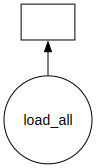

In [13]:
c.visualize(filename = 'test.svg')

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Can you read me
